In [ ]:
# Data Loading and Preprocessing
file_path = 'expanded_dummy_agriculture_dataset.csv'  # Update the file path if necessary
data = pd.read_csv(file_path)


In [ ]:
# Date Conversion and Feature Selection
data['date'] = pd.to_datetime(data['date'])
data_features = data.drop(['location', 'date'], axis=1)


In [ ]:
# Scaling the Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_features)
scaled_data = pd.DataFrame(scaled_data, columns=data_features.columns)


In [ ]:
# Sequence Creation for Time-Series Modeling
timesteps = 3  # Number of previous time steps to consider

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps, :-1])  # Features excluding target column
        y.append(data[i+timesteps, -1])     # Target (crop_yield)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data.values, timesteps)


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Model Definition
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

C:\Users\raymo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Model Compilation and Training
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4172 - val_loss: 0.3715
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3551 - val_loss: 0.2447
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1952 - val_loss: 0.0518
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0628 - val_loss: 0.0491
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0542 - val_loss: 0.0540
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0525 - val_loss: 0.0434
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0481 - val_loss: 0.0433
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0489 - val_loss: 0.0433
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443 - val_loss: 0.0427
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0425 - val_loss: 0.0424
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0478 - val_loss: 0.0423
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404 - val_loss: 0.0423
Epoch 13/50


In [ ]:
# Model Evaluation
mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on test data: {mse}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0489 
Mean Squared Error on test data: 0.04758153483271599


In [ ]:
# Output Additional Metrics

from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error on test data: {mae}")

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f"R-squared on test data: {r2}")

Mean Absolute Error on test data: 0.17608796425513734
R-squared on test data: -0.2065514544397995


In [ ]:
# Model Prediction and Inverse Scaling

predictions = model.predict(X_test)

# Inverse scaling
y_test_unscaled = scaler.inverse_transform(np.c_[np.zeros((y_test.shape[0], X_test.shape[2])), y_test])[:, -1]
predictions_unscaled = scaler.inverse_transform(np.c_[np.zeros((predictions.shape[0], X_test.shape[2])), predictions])[:, -1]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


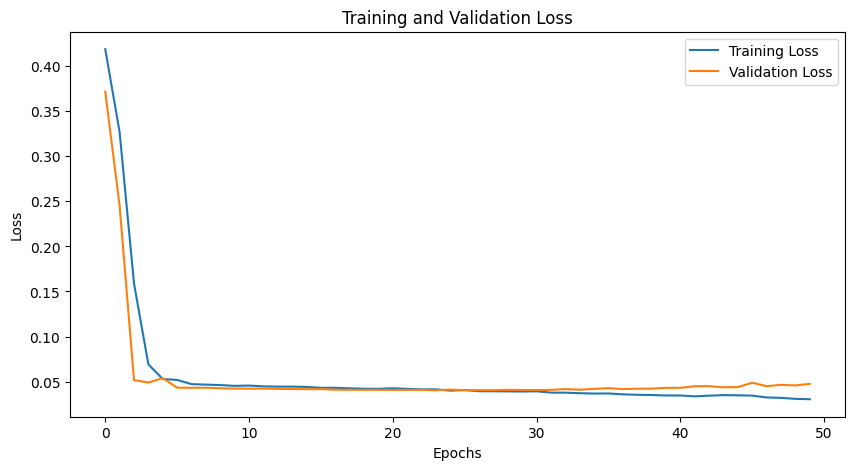

In [ ]:
# Visualize Training History

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

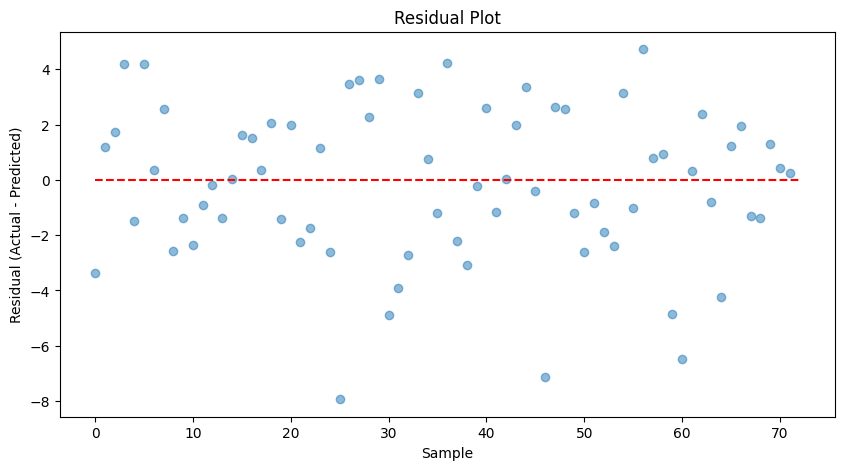

In [ ]:
# Residual Plot

residuals = y_test_unscaled - predictions_unscaled
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.hlines(0, xmin=0, xmax=len(residuals), colors='r', linestyles='--')
plt.title("Residual Plot")
plt.xlabel("Sample")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

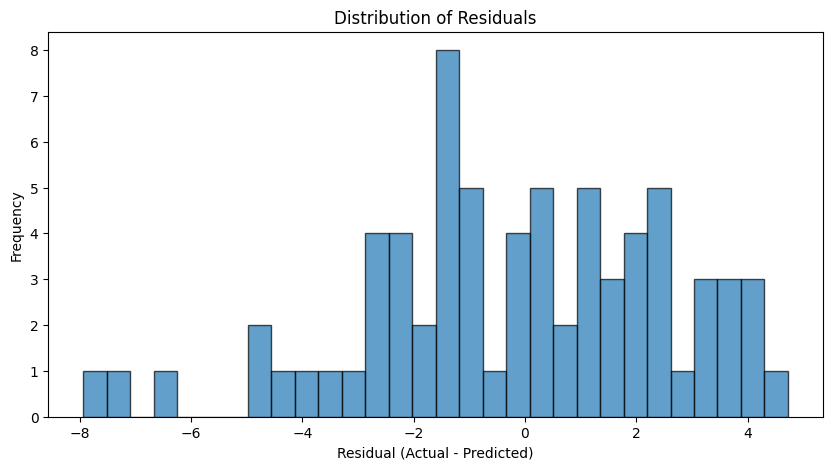

In [ ]:
#Error Distribution

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Feature Importance Analysis

def feature_importance_analysis(model, X, scaler, feature_names):
    for i, feature in enumerate(feature_names):
        X_noisy = X.copy()
        # Add small noise to the selected feature
        X_noisy[:, :, i] += np.random.normal(0, 0.1, X_noisy[:, :, i].shape)
        predictions_noisy = model.predict(X_noisy)
        predictions_noisy_unscaled = scaler.inverse_transform(np.c_[np.zeros((predictions_noisy.shape[0], X.shape[2])), predictions_noisy])[:, -1]
        mae_noisy = mean_absolute_error(y_test_unscaled, predictions_noisy_unscaled)
        print(f"Feature '{feature}' importance (increase in MAE): {mae_noisy - mae:.4f}")

feature_names = data_features.columns[:-1]  # All features except crop yield
feature_importance_analysis(model, X_test, scaler, feature_names)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Feature 'temperature' importance (increase in MAE): 2.0547
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Feature 'humidity' importance (increase in MAE): 2.0717
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature 'rainfall' importance (increase in MAE): 2.0430
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature 'wind_speed' importance (increase in MAE): 2.0310
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature 'PM2.5' importance (increase in MAE): 2.0539
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Feature 'PM10' importance (increase in MAE): 2.0233
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Feature 'NO2' importance (increase in MAE): 2.0462
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature 'CO' importance (increase in MAE): 2.0548
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Feature 'O3' importance (increase in MAE): 2.0165


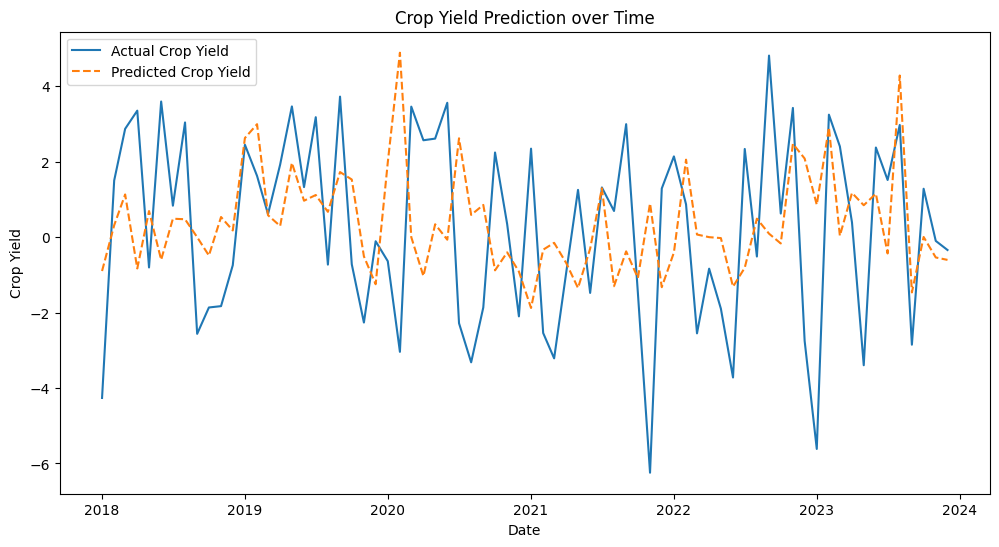

In [ ]:
# Time Series Analysis for Predictions

# Assuming the date column is still accessible
test_dates = data['date'].iloc[len(data) - len(y_test):]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_unscaled, label="Actual Crop Yield")
plt.plot(test_dates, predictions_unscaled, label="Predicted Crop Yield", linestyle='--')
plt.legend()
plt.title("Crop Yield Prediction over Time")
plt.xlabel("Date")
plt.ylabel("Crop Yield")
plt.show()

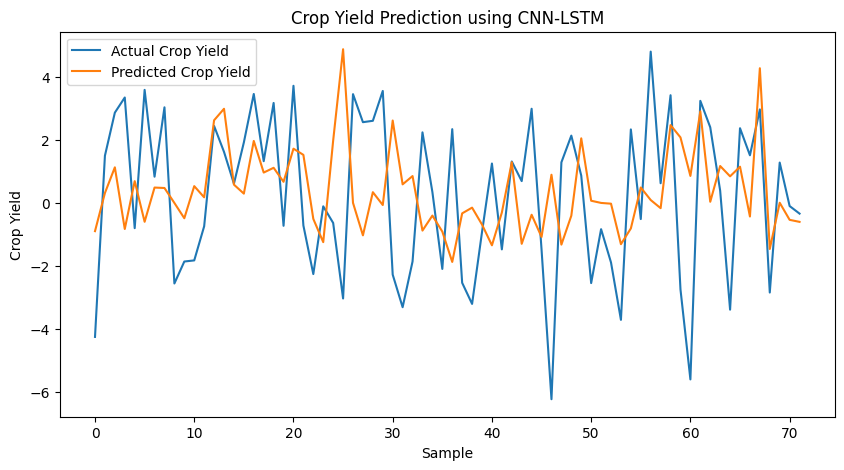

In [ ]:
# Result Visualization
plt.figure(figsize=(10, 5))
plt.plot(y_test_unscaled, label="Actual Crop Yield")
plt.plot(predictions_unscaled, label="Predicted Crop Yield")
plt.legend()
plt.title("Crop Yield Prediction using CNN-LSTM")
plt.xlabel("Sample")
plt.ylabel("Crop Yield")
plt.show()

In [ ]:
# Comparison of Predicted vs. Actual Values

comparison_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Crop Yield': y_test_unscaled,
    'Predicted Crop Yield': predictions_unscaled
})

print(comparison_df.head(10))  # Display the first 10 comparisons

          Date  Actual Crop Yield  Predicted Crop Yield
288 2018-01-01          -4.262352             -0.896851
289 2018-02-01           1.504340              0.317355
290 2018-03-01           2.873780              1.133879
291 2018-04-01           3.355930             -0.828994
292 2018-05-01          -0.802134              0.694330
293 2018-06-01           3.598414             -0.599057
294 2018-07-01           0.836116              0.490391
295 2018-08-01           3.043179              0.476023
296 2018-09-01          -2.562467              0.000300
297 2018-10-01          -1.863289             -0.486161
